# Preprocessing 

1) Import and remove corrupt/inconsistant/unnecessary data

2) Drop cols. with >60% missing data (nan values) 

3) Remove highly corrilated features with corrilation above 70%

4) Change target variable 'pick' to 1 if value is 1-60, else to 0

5) Merge each individual player into 1 row/player

6) Remove all players who still have >15% missing data 

7) split into training and testing data

8) Use KNN to fill in any remaining missing data/Nan values

9) Feature selection with random forest classifier 



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn import metrics, preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


In [2]:
playerDf = pd.read_csv('data/CollegeBasketballPlayers2009-2021.csv', low_memory=False)

#initial dropping of inconsistant data for player data 
playerDf = playerDf.rename(columns = {'Unnamed: 64' : 'role_position'})
playerDf = playerDf.drop('Unnamed: 65', axis=1) # Has no meaning in the dataset
playerDf = playerDf.drop('ht', axis=1) # Temporarily excluding this column due to inconsistent date formats and other values
playerDf = playerDf.drop('num', axis=1) # It might denote a player's choice or position but with significant variation in meaning.
playerDf = playerDf.drop('type', axis=1) # Column has 1 unique value
playerDf= playerDf.drop('pid', axis=1) # catigorical, not needed 
playerDf= playerDf.drop('yr', axis=1) # catigorical, not needed 

print(playerDf.shape)

(61061, 60)


In [3]:
# Count and remove columns with over 60% nan values from players
total = len(playerDf)
for column in playerDf.columns:
    count = playerDf[column].isna().sum()
    percent= (count/ total) * 100
    if (percent>=60):
        print(f"Player  DF: Column '{column}':", f"Number of NaN: {count}", f"Percentage: {percent:.2f}%")

Player  DF: Column 'Rec Rank': Number of NaN: 42591 Percentage: 69.75%
Player  DF: Column 'pick': Number of NaN: 59626 Percentage: 97.65%


In [4]:
playerDf = playerDf.drop('Rec Rank', axis=1) 

In [5]:
#remove redundant/highly corrilated data 
player_corr_matrix = playerDf.corr()
correlation_threshold = 0.9
corr_df = playerDf.corr().abs()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)

# Find columns that meet threshold
features_to_drop = [c for c in tri_df.columns if any(tri_df[c] >= correlation_threshold)]
print(features_to_drop)

['Min_per', 'Ortg', 'eFG', 'FTM', 'twoPM', 'twoPA', 'TPM', 'rimmade', 'midmade', 'dunksmade', 'drtg', 'dporpag', 'stops', 'gbpm', 'mp', 'dreb']


In [6]:
# Remove the highly correlated features from the DataFrame
playerDf = playerDf.drop(columns=features_to_drop, axis=1)

# Display the new shape of the DataFrame
print("Shape of the DataFrame after removing highly correlated features:", playerDf.shape)

Shape of the DataFrame after removing highly correlated features: (61061, 43)


In [7]:
#if drafted, change to 1 since values for drafted are 1-60 and not drafted is saved as nan
playerDf.loc[playerDf["pick"] > 0, "pick"] = 1
#not drafted was nan, replace with 0 
playerDf.loc[playerDf["pick"] != 1, "pick"] = 0

In [8]:
#merge the players so 1 player/row
categorical_columns = ['player_name', 'team', 'role_position', 'conf']

# Function to calculate weighted average
def weighted_avg(group):
    categorical_data = group.iloc[-1, group.columns.isin(categorical_columns)]
    data_to_ave = group.drop(columns=categorical_columns).mean(numeric_only=True)
    
    if any(group['pick'] == 1):
        group['pick'] = 1
    return pd.concat([categorical_data, data_to_ave])

# Group by player name and team, then apply weighted average
playerDf['player_name'] = playerDf['player_name'].str.lower()
player_grouped = playerDf.groupby(['player_name', 'team'], as_index=False).apply(weighted_avg)
player_grouped.reset_index(drop=True, inplace=True)

In [9]:
print(playerDf.shape)
print(player_grouped.shape)

(61061, 43)
(30200, 43)


In [10]:
playerDf=player_grouped

In [11]:
#drop any players who still have >15% missing values 
threshold = 15
missing_percentage = (playerDf.isnull().sum(axis=1) / playerDf.shape[1]) * 100
rows_to_drop = []

for index, percentage in missing_percentage.iteritems():
    if percentage > threshold:
        rows_to_drop.append(index)

playerDf = playerDf.drop(index=rows_to_drop)

In [12]:
#don't need name anymore 
playerDf = playerDf.drop('player_name', axis=1) 

In [13]:
#Encode catigorical data 
team_label_encoder = LabelEncoder()
playerDf['team'] = team_label_encoder.fit_transform(playerDf['team'])

conf_label_encoder = LabelEncoder()
playerDf['conf'] = conf_label_encoder.fit_transform(playerDf['conf'])

role_position_label_encoder = LabelEncoder()
playerDf['role_position'] = role_position_label_encoder.fit_transform(playerDf['role_position'])


In [14]:
#split into training and testing data to avoid any overlap 
trainDf=playerDf.loc[playerDf['year'] <2021]
testDf= playerDf.loc[playerDf['year'] >= 2021]

In [15]:
print(trainDf.shape)
print(testDf.shape)

(25322, 42)
(2409, 42)


In [16]:
#KNN fill in NAN values 
def fillNan(df):
    imputer = KNNImputer(n_neighbors=11)
    imputed_numeric = imputer.fit_transform(df.select_dtypes(include=np.number))
    dfBasketballTraining_filled = pd.DataFrame(imputed_numeric, columns=df.select_dtypes(include=np.number).columns)

    string_columns = df.select_dtypes(include='object').columns
    imputed_data = pd.concat([df[string_columns].reset_index(drop=True), dfBasketballTraining_filled], axis=1)

    return pd.DataFrame(imputed_data, columns=df.columns)

In [17]:
trainDf=fillNan(trainDf)
testDf=fillNan(testDf)

In [18]:
#Scale data  
def scaleData(df):
    exclude=['team', 'conf', 'year', 'role_position', 'pick']
    colToScale= [col for col in df.columns if col not in exclude]
    
    scaler = StandardScaler()
    scaledData = df.copy()  
    scaledData[colToScale] = scaler.fit_transform(df[colToScale])
    
    return pd.DataFrame(scaledData, columns=df.columns) 

In [19]:
trainDf=scaleData(trainDf)
testDf=scaleData(testDf)

In [20]:
#feature selection with random forest 
X = trainDf.drop("pick", axis=1)
y = trainDf["pick"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

#importance
sel = SelectFromModel(rf_classifier)
sel.fit(X_train, y_train)

# Get support and selected feature names
selected_feature_indices = sel.get_support()
selected_features = X_train.columns[selected_feature_indices]

print("Selected features:")
print(selected_features)

print("Feature importance scores:")
print(sel.estimator_.feature_importances_)


Selected features:
Index(['GP', 'FTA', 'porpag', 'adjoe', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm',
       'pts'],
      dtype='object')
Feature importance scores:
[0.01553067 0.012796   0.00572521 0.06102807 0.01617055 0.01634001
 0.01501077 0.01352909 0.01424418 0.01593397 0.03480428 0.01620879
 0.01503029 0.01509984 0.01140582 0.01510227 0.01259192 0.01483167
 0.0804282  0.03246808 0.01698018 0.01089619 0.01603004 0.02259632
 0.03323672 0.01649195 0.01455238 0.04188307 0.01314135 0.04692818
 0.07713614 0.03343533 0.02605503 0.04383098 0.02810594 0.01524544
 0.02183689 0.01794077 0.01561047 0.02138466 0.0324023 ]


# Model 

1) Model: first tested training with k-fold cross validation 

2) Model: second tested training by balancing data 

## Model: training with k-fold cross validation

In [21]:
def get_training_data(data, start, stop, end=False):
    if end==False: 
        subset = data.iloc[start:stop]
    else: #include the raminder of the samples in the last set 
        subset = data.iloc[start:]
    return subset

def kFoldTrain(model, sets, features, target='pick'):
    prefMetrics = {'Validation set': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
    correctPred = 0
    totalPred = 0

    for j in range(len(sets)):
        valSet = sets[j]
        
        for i in range(len(sets)):
            # Don't train validation set against the validation set 
            if i != j:
                # Remove the target variable pick from the training and testing data 
                trainSet = sets[i]
                trainNoTarget = trainSet[features]
                trainTarget = trainSet[target]
                valNoTarget = valSet[features]
                valTarget = valSet[target]
                
                model.fit(trainNoTarget, trainTarget)
                
                # Make predictions with the validation set 
                predVals = model.predict(valNoTarget)

                # Calculate metrics
                prefMetrics['Validation set'].append(j+1)
                prefMetrics['Precision'].append(precision_score(valTarget, predVals))
                prefMetrics['Recall'].append(recall_score(valTarget, predVals))
                prefMetrics['F1 Score'].append(f1_score(valTarget, predVals))

                # Update correct predictions and total predictions for expected preformance accuracy 
                correctPred += np.sum(predVals == valTarget)
                totalPred += len(valTarget)

    expAccuracy = correctPred / totalPred

    return expAccuracy, prefMetrics
                

In [22]:
trainDf.columns

Index(['team', 'conf', 'role_position', 'GP', 'usg', 'TS_per', 'ORB_per',
       'DRB_per', 'AST_per', 'TO_per', 'FTA', 'FT_per', 'twoP_per', 'TPA',
       'TP_per', 'blk_per', 'stl_per', 'ftr', 'porpag', 'adjoe', 'pfr', 'year',
       'ast/tov', 'rimmade+rimmiss', 'midmade+midmiss',
       'rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)',
       'dunksmiss+dunksmade', 'dunksmade/(dunksmade+dunksmiss)', 'pick',
       'adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'oreb', 'treb', 'ast',
       'stl', 'blk', 'pts'],
      dtype='object')

In [23]:
#get divided training data for k-crossfold validation 
# features=['porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']
# features=selected_features
features=['usg', 'DRB_per', 'AST_per', 'TO_per', 'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']
# features= [ 'treb', 'ast','stl', 'blk', 'pts']

numFeatures= len(features)
rows=trainDf.shape[0]
numSets=5
perSet = int(rows/numSets)

#shuffle
trainDf = trainDf.sample(frac=1, random_state=42).reset_index(drop=True)

# 6 sets
numSets=6
perSet = int(rows/numSets)

set1=get_training_data(trainDf, 0,perSet) 
set2=get_training_data(trainDf, perSet, perSet*2) 
set3=get_training_data(trainDf, perSet*2, perSet*3) 
set4=get_training_data(trainDf, perSet*3, perSet*4) 
set5=get_training_data(trainDf, perSet*4, perSet*5) 
set6=get_training_data(trainDf, perSet*5, 0, True) #set will inclide any extera entries 

trainingSets=[set1, set2, set3, set4, set5, set6]


In [24]:
#citations: 
#video: https://aleksandarhaber.com/ensemble-learning-in-scikit-learn-voting-classifiers/
#Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#build model 

#the 3 models for the ensemble 
logreg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
randFor = RandomForestClassifier(n_estimators=53, random_state=42)
svm = SVC(probability=True, random_state=42) 

                                     
# voting ensemble classifier 
model = VotingClassifier(estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='hard')

ExpAccuracy,trainMetrics=kFoldTrain(model, trainingSets, features)
metricDf=pd.DataFrame(trainMetrics)

In [25]:
print("Accuracy estimate for the model: ", ExpAccuracy)
print("Precision estimate for the model: ", metricDf['Precision'].mean())
print("Recall estimate for the model: ", metricDf['Recall'].mean())
print("F1 Score estimate for the model: ", metricDf['F1 Score'].mean())

Accuracy estimate for the model:  0.9792354474370113
Precision estimate for the model:  0.7385287572190667
Recall estimate for the model:  0.20006577421359054
F1 Score estimate for the model:  0.31040812314916316


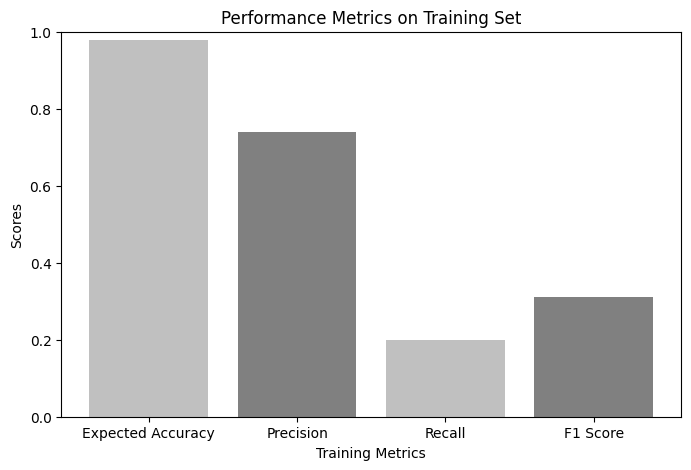

In [26]:
#plot training 
metrics = ['Expected Accuracy','Precision', 'Recall', 'F1 Score']
scores = [ExpAccuracy, metricDf['Precision'].mean(), metricDf['Recall'].mean() , metricDf['F1 Score'].mean()]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['silver', 'grey', 'silver', 'grey'])
plt.xlabel('Training Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics on Training Set')
plt.ylim(0, 1)
plt.show()

In [27]:
#test the model 
testNoPick=testDf[features]
testPick=testDf['pick']

# Predict if player was selected for the draft on the test set
predTest = model.predict(testNoPick)

#preformance metrics for test set
tPrecision = precision_score(testPick, predTest)
tRecall = recall_score(testPick, predTest)
tF1 = f1_score(testPick, predTest)


In [28]:
tAccuracy = accuracy_score(testPick, predTest)

print('Accuracy on Test Set:', tAccuracy)
print('Precision on Test Set:', tPrecision)
print('Recall on Test Set:', tRecall)
print('F1-score on Test Set:', tF1)

Accuracy on Test Set: 0.9904524699045247
Precision on Test Set: 0.2857142857142857
Recall on Test Set: 0.1
F1-score on Test Set: 0.14814814814814817


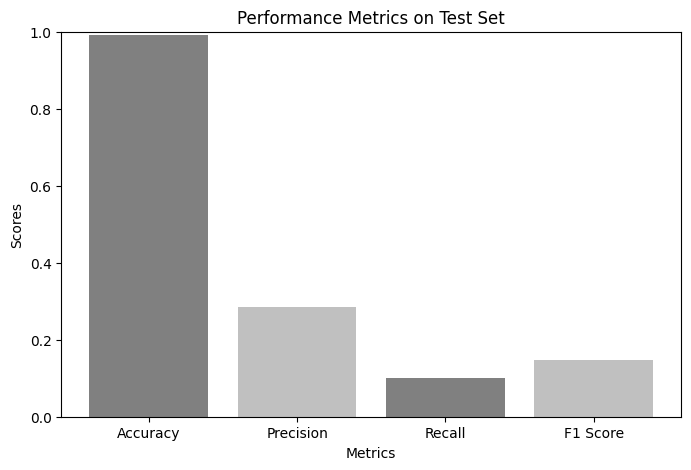

In [29]:
#plot testing 
metrics = ['Accuracy','Precision', 'Recall', 'F1 Score']
scores = [tAccuracy,tPrecision, tRecall , tF1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['grey','silver', 'grey', 'silver'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics on Test Set')
plt.ylim(0, 1)
plt.show()

## Test run pref values for cross fold and various features selected:

1) 5 training sets, features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'blk', 'pts']
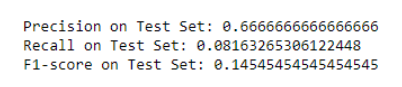

2) 5 training sets, features=['usg', 'DRB_per', 'AST_per', 'TO_per',  'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']

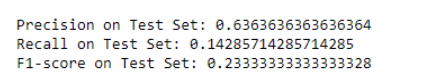

3) 5 training sets, features=['porpag', 'adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']

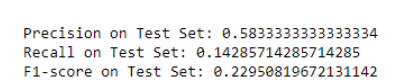

## best
4) 6 training sets, features=['porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']

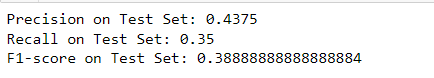

5) 6 training sets, features=['conf', 'role_position','rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)',
       'dunksmiss+dunksmade', 'dunksmade/(dunksmade+dunksmiss)', 'ast','stl', 'blk']

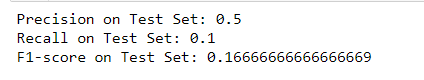

6) 6 training sets,  features=[ 'treb', 'ast','stl', 'blk', 'pts']

0's across the board 


Conclusion, aggrigated data values 'porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm' as well as 'pts' are best predictors. Knowing how the agrigated values are found can help players understand what areas they need to improve to increase odd of being drafted.


## Model: training with balanced data

In [ ]:
def get_training_data(dataframe, replacement, features = 13, multiplicity = 10):
    trainingCount = int(features*multiplicity/2)
    not_drafted = dataframe[dataframe['pick'] == 0].sample(n=trainingCount, replace=replacement)
    drafted = dataframe[dataframe['pick'] == 1].sample(n=trainingCount, replace=replacement)
    return pd.concat([not_drafted, drafted], ignore_index=True)

def trainRandSets(model, features, sets, target='pick'): 
    prefMetrics = {'Precision': [], 'Recall': [], 'F1 Score': []}

    for data in sets:
        y = data[target]
        X = data.drop(target, axis=1) 
        
        trainTarget, valTarget, trainNoTarget, valNoTarget = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train
        model.fit(trainNoTarget, trainTarget)  

        predVals = model.predict(valNoTarget)

        prefMetrics['Precision'].append(precision_score(valTarget, predVals))
        prefMetrics['Recall'].append(recall_score(valTarget, predVals))
        prefMetrics['F1 Score'].append(f1_score(valTarget, predVals))

    return prefMetrics